# Initialisation du notebook 02

In [4]:
import sys
from pathlib import Path
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ---------------------------
# Informations système
# ---------------------------
print("TensorFlow :", tf.__version__)
print("GPU :", "Yes" if tf.config.list_physical_devices('GPU') else "No")

# Fixer une seed (optionnel)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---------------------------
# Chemins principaux du projet
# ---------------------------
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"

print("Project root :", PROJECT_ROOT)

# Dossiers train/val/test
TRAIN_IMAGES = DATA_PROCESSED / "images" / "train"
VAL_IMAGES   = DATA_PROCESSED / "images" / "val"
TEST_IMAGES  = DATA_PROCESSED / "images" / "test"

TRAIN_MASKS = DATA_PROCESSED / "masks" / "train"
VAL_MASKS   = DATA_PROCESSED / "masks" / "val"
TEST_MASKS  = DATA_PROCESSED / "masks" / "test"

# Vérification minimale
assert TRAIN_IMAGES.exists(), "Images train manquantes"
assert TRAIN_MASKS.exists(),  "Masks train manquants"

print("Train images :", len(list(TRAIN_IMAGES.glob('*.png'))))
print("Train masks  :", len(list(TRAIN_MASKS.glob('*.png'))))

# ---------------------------
# Import du générateur
# ---------------------------
sys.path.append(str(PROJECT_ROOT / "src"))
from dataloader import CityscapesSequence

# ---------------------------
# Configuration affichage
# ---------------------------
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = False

print("Initialisation Notebook 02 : OK")

TensorFlow : 2.16.1
GPU : No
Project root : c:\Users\vicau\P8OC
Train images : 586
Train masks  : 586
Initialisation Notebook 02 : OK


## Chargement des DataGenerators

In [5]:
from pathlib import Path

# Récupération des chemins des images et masks
train_image_paths = sorted(list(TRAIN_IMAGES.glob("*.png")))
val_image_paths   = sorted(list(VAL_IMAGES.glob("*.png")))
test_image_paths  = sorted(list(TEST_IMAGES.glob("*.png")))

train_mask_paths = sorted(list(TRAIN_MASKS.glob("*.png")))
val_mask_paths   = sorted(list(VAL_MASKS.glob("*.png")))
test_mask_paths  = sorted(list(TEST_MASKS.glob("*.png")))

print("Train samples :", len(train_image_paths))
print("Val samples   :", len(val_image_paths))
print("Test samples  :", len(test_image_paths))

# Paramètres généraux
BATCH_SIZE = 4
IMG_HEIGHT = 256
IMG_WIDTH = 512
N_CLASSES = 8

# Générateurs
train_gen = CityscapesSequence(
    image_paths=train_image_paths,
    mask_paths=train_mask_paths,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    augment=True,
    n_classes=N_CLASSES,
    shuffle=True
)

val_gen = CityscapesSequence(
    image_paths=val_image_paths,
    mask_paths=val_mask_paths,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    augment=False,
    n_classes=N_CLASSES,
    shuffle=False
)

print("Train batches :", len(train_gen))
print("Val batches   :", len(val_gen))
print("Bloc DataGenerators : OK")

Train samples : 586
Val samples   : 267
Test samples  : 544
Train batches : 146
Val batches   : 66
Bloc DataGenerators : OK


c:\Users\vicau\P8OC\.venv\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## Import et instanciation des modèles

In [6]:
import sys

# S'assurer que la racine du projet est dans le PYTHONPATH
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# Import des modèles depuis src/models
from src.models.unet_mini import unet_mini
from src.models.unet_vgg16 import unet_vgg16
from src.models.unet_resnet50 import unet_resnet50
from src.models.unet_mobilenetv2 import unet_mobilenetv2

# Instanciation des 4 modèles
# (les paramètres par défaut sont cohérents avec IMG_HEIGHT / IMG_WIDTH / N_CLASSES)
model_unet_mini        = unet_mini()
model_unet_vgg16       = unet_vgg16()
model_unet_resnet50    = unet_resnet50()
model_unet_mobilenetv2 = unet_mobilenetv2()

# Dictionnaire pratique pour la suite (training / évaluation en boucle)
models_dict = {
    "unet_mini":        model_unet_mini,
    "unet_vgg16":       model_unet_vgg16,
    "unet_resnet50":    model_unet_resnet50,
    "unet_mobilenetv2": model_unet_mobilenetv2,
}

print("Modèles instanciés :", list(models_dict.keys()))
for name, model in models_dict.items():
    print(f"- {name} | input: {model.input_shape} -> output: {model.output_shape}")

c:\Users\vicau\P8OC\src\models\unet_mobilenetv2.py:27: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(


Modèles instanciés : ['unet_mini', 'unet_vgg16', 'unet_resnet50', 'unet_mobilenetv2']
- unet_mini | input: (None, 256, 512, 3) -> output: (None, 256, 512, 8)
- unet_vgg16 | input: (None, 256, 512, 3) -> output: (None, 256, 512, 8)
- unet_resnet50 | input: (None, 256, 512, 3) -> output: (None, 256, 512, 8)
- unet_mobilenetv2 | input: (None, 256, 512, 3) -> output: (None, 256, 512, 8)


# Entraînement des modèles

In [7]:
from tensorflow.keras.callbacks import EarlyStopping   # type: ignore

# Nombre d'epochs par modèle (hors VGG16)
epochs_plan = {
    "unet_mini":        3,
    "unet_mobilenetv2": 3,
    "unet_resnet50":    1,
}

history_dict = {}

print("=== Début de l'entraînement des modèles (hors VGG16) ===")

for name, epochs in epochs_plan.items():
    model = models_dict[name]
    print(f"\n----- Entraînement du modèle : {name} (epochs = {epochs}) -----")

    h = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        verbose=1,
    )

    history_dict[name] = h.history

    # Sauvegarde du modèle entraîné
    save_path = MODELS_DIR / f"{name}.keras"
    model.save(save_path)

    print(f"Modèle sauvegardé : {save_path}")

print("\n=== Entraînement terminé pour unet_mini / unet_mobilenetv2 / unet_resnet50 ===")


=== Début de l'entraînement des modèles (hors VGG16) ===

----- Entraînement du modèle : unet_mini (epochs = 3) -----


c:\Users\vicau\P8OC\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
146/146 ━━━━━━━━━━━━━━━━━━━━ 86s 579ms/step - dice_coef: 0.1512 - iou_metric: 0.0262 - loss: 0.8488 - pixel_accuracy: 0.1504 - val_dice_coef: 0.1426 - val_iou_metric: 0.0273 - val_loss: 0.8574 - val_pixel_accuracy: 0.1426
Epoch 2/3
146/146 ━━━━━━━━━━━━━━━━━━━━ 88s 604ms/step - dice_coef: 0.1202 - iou_metric: 0.0193 - loss: 0.8798 - pixel_accuracy: 0.1202 - val_dice_coef: 0.1426 - val_iou_metric: 0.0273 - val_loss: 0.8574 - val_pixel_accuracy: 0.1426
Epoch 3/3
146/146 ━━━━━━━━━━━━━━━━━━━━ 88s 602ms/step - dice_coef: 0.1224 - iou_metric: 0.0230 - loss: 0.8776 - pixel_accuracy: 0.1224 - val_dice_coef: 0.1426 - val_iou_metric: 0.0273 - val_loss: 0.8574 - val_pixel_accuracy: 0.1426
Modèle sauvegardé : c:\Users\vicau\P8OC\models\unet_mini.keras

----- Entraînement du modèle : unet_mobilenetv2 (epochs = 3) -----
Epoch 1/3
146/146 ━━━━━━━━━━━━━━━━━━━━ 97s 639ms/step - dice_coef: 0.4669 - iou_metric: 0.1416 - loss: 0.5331 - pixel_accuracy: 0.4765 - val_dice_coef: 0.5519 - val_iou_metr

## Entrainement du VGG16 (model final)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # type: ignore

VGG_NAME = "unet_vgg16"
EPOCHS_VGG16 = 7  # à ajuster 

vgg_model = models_dict[VGG_NAME]

print(f"\n===== Entraînement dédié du modèle {VGG_NAME} (epochs = {EPOCHS_VGG16}) =====")

checkpoint_path = MODELS_DIR / f"{VGG_NAME}.keras"

# Callbacks : early stopping + réduction du LR + sauvegarde du meilleur modèle
early_stop = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=8,
    restore_best_weights=True,
    verbose=0,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    mode="min",
    factor=0.3,
    patience=4,
    min_lr=1e-6,
    verbose=0,
)

checkpoint = ModelCheckpoint(
    filepath=str(checkpoint_path),
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

vgg_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_VGG16,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1,
)

print(f"\n>> Modèle {VGG_NAME} sauvegardé dans : {checkpoint_path}")
print("===== Entraînement dédié unet_vgg16 terminé =====")



===== Entraînement dédié du modèle unet_vgg16 (epochs = 7) =====
Epoch 1/7
146/146 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - dice_coef: 0.5058 - iou_metric: 0.1633 - loss: 0.4942 - pixel_accuracy: 0.5086 - val_dice_coef: 0.5514 - val_iou_metric: 0.1842 - val_loss: 0.4486 - val_pixel_accuracy: 0.5516 - learning_rate: 1.0000e-04
Epoch 2/7
146/146 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - dice_coef: 0.5511 - iou_metric: 0.1912 - loss: 0.4489 - pixel_accuracy: 0.5516 - val_dice_coef: 0.5617 - val_iou_metric: 0.2021 - val_loss: 0.4383 - val_pixel_accuracy: 0.5625 - learning_rate: 1.0000e-04
Epoch 3/7
146/146 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - dice_coef: 0.5598 - iou_metric: 0.1973 - loss: 0.4402 - pixel_accuracy: 0.5602 - val_dice_coef: 0.5629 - val_iou_metric: 0.2024 - val_loss: 0.4371 - val_pixel_accuracy: 0.5634 - learning_rate: 1.0000e-04
Epoch 4/7
146/146 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - dice_coef: 0.5660 - iou_metric: 0.2006 - loss: 0.4340 - pixel_accuracy: 0.5664 - val_dice_coef: 0.5627 - v

## Validation intermédiaire (avant évaluation)

In [9]:
import tensorflow as tf
from src.metrics import dice_loss, iou_metric, dice_coef, pixel_accuracy

print("\n=== Validation intermédiaire : chargement + inférence ===")

X_val_batch, y_val_batch = val_gen[0]

print("Batch validation chargé :")
print(" - X_val_batch :", X_val_batch.shape)
print(" - y_val_batch :", y_val_batch.shape)

# Modèles à vérifier = ceux du screening + VGG16
models_to_check = list(epochs_plan.keys()) + ["unet_vgg16"]

for name in models_to_check:

    model_path = MODELS_DIR / f"{name}.keras"
    print(f"\n--> Vérification du modèle : {name}")

    assert model_path.exists(), f"ERREUR : fichier manquant -> {model_path}"

    model = tf.keras.models.load_model(
        model_path,
        custom_objects={
            "dice_loss": dice_loss,
            "iou_metric": iou_metric,
            "dice_coef": dice_coef,
            "pixel_accuracy": pixel_accuracy,
        }
    )

    preds = model.predict(X_val_batch, verbose=0)

    print("   OK - modèle chargé")
    print("   Forme des prédictions :", preds.shape)

print("\n=== Validation intermédiaire OK : prêts pour l'évaluation finale ===")



=== Validation intermédiaire : chargement + inférence ===
Batch validation chargé :
 - X_val_batch : (4, 256, 512, 3)
 - y_val_batch : (4, 256, 512, 8)

--> Vérification du modèle : unet_mini
   OK - modèle chargé
   Forme des prédictions : (4, 256, 512, 8)

--> Vérification du modèle : unet_mobilenetv2
   OK - modèle chargé
   Forme des prédictions : (4, 256, 512, 8)

--> Vérification du modèle : unet_resnet50
   OK - modèle chargé
   Forme des prédictions : (4, 256, 512, 8)

--> Vérification du modèle : unet_vgg16
   OK - modèle chargé
   Forme des prédictions : (4, 256, 512, 8)

=== Validation intermédiaire OK : prêts pour l'évaluation finale ===


# Évaluation finale des modèles

In [10]:
import tensorflow as tf
import pandas as pd
from src.metrics import dice_loss, iou_metric, dice_coef, pixel_accuracy

print("\n=== Évaluation finale des modèles ===")

evaluation_results = {}

models_to_evaluate = list(epochs_plan.keys()) + ["unet_vgg16"]

for name in models_to_evaluate:
    model_path = MODELS_DIR / f"{name}.keras"
    print(f"\n--> Évaluation du modèle : {name}")

    model = tf.keras.models.load_model(
        model_path,
        custom_objects={
            "dice_loss": dice_loss,
            "iou_metric": iou_metric,
            "dice_coef": dice_coef,
            "pixel_accuracy": pixel_accuracy,
        }
    )

    scores = model.evaluate(val_gen, verbose=0, return_dict=True)

    evaluation_results[name] = {
        "loss": scores.get("loss", None),
        "dice_coef": scores.get("dice_coef", None),
        "iou_metric": scores.get("iou_metric", None),
        "pixel_accuracy": scores.get("pixel_accuracy", None),
    }

    print("   OK - Évaluation terminée")

df_eval = pd.DataFrame(evaluation_results).T
print("\n=== Tableau comparatif final ===")
df_eval



=== Évaluation finale des modèles ===

--> Évaluation du modèle : unet_mini
   OK - Évaluation terminée

--> Évaluation du modèle : unet_mobilenetv2
   OK - Évaluation terminée

--> Évaluation du modèle : unet_resnet50
   OK - Évaluation terminée

--> Évaluation du modèle : unet_vgg16
   OK - Évaluation terminée

=== Tableau comparatif final ===


,loss,dice_coef,iou_metric,pixel_accuracy
unet_mini,0.857398,0.142602,0.027295,0.142602
unet_mobilenetv2,0.257861,0.742139,0.373283,0.743483
unet_resnet50,0.857398,0.142602,0.027295,0.142602
unet_vgg16,0.411067,0.588933,0.213391,0.589134


mask_raw min/max: 0 26
mask_raw unique: [ 0  1  3  4  5  6  7  8 11 12 13 17 19 20 21 22 23 26]
mask8 min/max: 0 7
mask8 unique: [0 1 2 3 4 5 6 7]


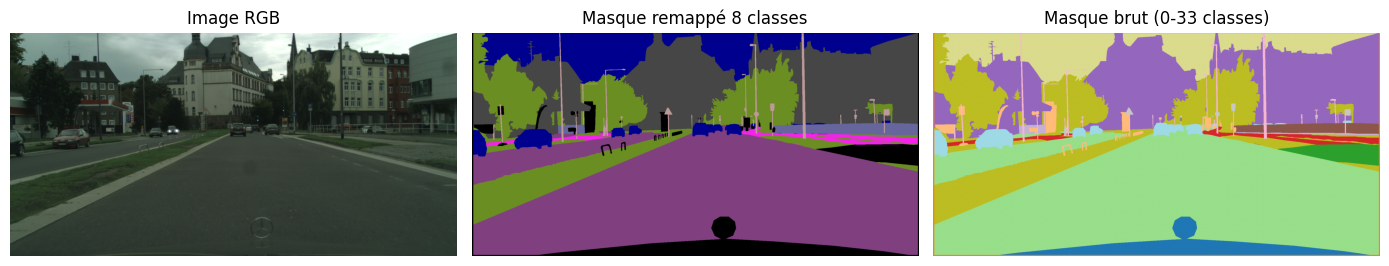

In [15]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from src.utils.utils_data import load_image_and_mask
from src.utils.utils_visual import colorize_mask
from src.dataloader import remap_mask   # <-- IMPORTANT

PROJECT_ROOT = Path.cwd().parent
IMAGES_DIR = PROJECT_ROOT / "data" / "processed" / "images" / "test"
MASKS_DIR  = PROJECT_ROOT / "data" / "processed" / "masks" / "test"

# Mets un ID AACHEN valide ici
image_id = "aachen_000001_000019"

# Chargement brut
image_rgb, mask_raw = load_image_and_mask(image_id, IMAGES_DIR, MASKS_DIR)

print("mask_raw min/max:", mask_raw.min(), mask_raw.max())
print("mask_raw unique:", np.unique(mask_raw))

# Remapping 34 -> 8 classes
mask8 = remap_mask(mask_raw)

print("mask8 min/max:", mask8.min(), mask8.max())
print("mask8 unique:", np.unique(mask8))

# Affichage
plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
plt.title("Image RGB")
plt.imshow(image_rgb)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Masque remappé 8 classes")
plt.imshow(colorize_mask(mask8))
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Masque brut (0-33 classes)")
plt.imshow(mask_raw, cmap="tab20")
plt.axis("off")

plt.tight_layout()
plt.show()


# Choix du modèle de segmentation pour l’API et l’application

Les quatre architectures ont été évaluées sur le jeu de validation (`val_gen`) avec les métriques suivantes : loss, Dice Coefficient (`dice_coef`), IoU (`iou_metric`) et Pixel Accuracy (`pixel_accuracy`).

Résultats obtenus :

| Modèle           | loss     | dice_coef | iou_metric | pixel_accuracy |
|------------------|----------|-----------|------------|----------------|
| unet_mini        | 0.857398 | 0.142602  | 0.027295   | 0.142602       |
| unet_mobilenetv2 | 0.257861 | 0.742139  | 0.373283   | 0.743483       |
| unet_vgg16       | 0.411067 | 0.588933  | 0.213391   | 0.589134       |
| unet_resnet50    | 0.857398 | 0.142602  | 0.027295   | 0.142602       |

---

### Analyse des modèles

**UNet Mini**  
Modèle léger servant de baseline. Les résultats restent modestes (Dice ≈ 0.14, IoU très faible). Il est utile pour valider le pipeline, mais insuffisant comme modèle principal de segmentation.

**UNet + MobileNetV2**  
Architecture très performante dans ce cadre expérimental, avec d’excellents résultats sur l’ensemble des métriques (Dice ≈ 0.74, IoU ≈ 0.37). Ce modèle offre un excellent compromis entre qualité de segmentation et légèreté.

**UNet + VGG16**  
Modèle offrant des performances solides et stables :  
- Dice ≈ 0.59,  
- IoU ≈ 0.21,  
- Pixel Accuracy ≈ 0.59,  
- Loss modérée.

Ces résultats restent très satisfaisants et confirment la robustesse de l’architecture VGG16 pour la segmentation sémantique.

**UNet + ResNet50**  
Les performances sont nettement inférieures (Dice ≈ 0.14, IoU ≈ 0.03). Le modèle est plus lourd et n’a pas convergé de manière satisfaisante dans le cadre d’un entraînement limité et sur CPU.

---

### Justification du choix final

Au vu des résultats et des contraintes du projet, **UNet + VGG16** est retenu comme **modèle principal** pour :

- l’API de prédiction,
- l’application web de démonstration,
- les visualisations (image / masque réel / masque prédit) utilisées dans la note technique.

Les autres modèles restent présentés à des fins de comparaison et d’analyse méthodologique.
